## [시계열데이터처리] 비트코인 시세예측
##### 2017-2020년, 3년의 데이터를 가지고 4월 한달간 비트코인 변화 예측

#### 시계열 데이터란

#### 데이터 로드

In [248]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [249]:
# 3년치 데이터 로드
train_path = 'train.csv'
train = pd.read_csv(train_path)

In [250]:
# 4월 데이터 로드 (04-25 기준)
test_path = 'test.csv'
test = pd.read_csv(test_path)

In [251]:
print(train.shape)
print(test.shape)

(1070, 2)
(25, 2)


In [252]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 2 columns):
Timestamp    1070 non-null object
price        1070 non-null float64
dtypes: float64(1), object(1)
memory usage: 16.8+ KB


In [253]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 2 columns):
Timestamp    25 non-null object
price        25 non-null float64
dtypes: float64(1), object(1)
memory usage: 528.0+ bytes


In [254]:
train.head()

,Timestamp,price
0,2017-04-27 0:00,1240.794286
1,2017-04-28 0:00,1252.654286
2,2017-04-29 0:00,1266.040000
3,2017-04-30 0:00,1278.481429
4,2017-05-01 0:00,1292.732857


In [255]:
test.head()

,Timestamp,price
0,2020-04-01 0:00,6428.28
1,2020-04-02 0:00,6652.87
2,2020-04-03 0:00,6809.11
3,2020-04-04 0:00,6741.67
4,2020-04-05 0:00,6871.69


#### 가격 추이 시각화

In [256]:
# to_datetime 메소드를 통해 day 피처를 시계열 피처 처리
train['Timestamp'] = pd.to_datetime(train['Timestamp'])
# 프레임 인덱스 설정
train.index = train['Timestamp']
train.set_index('Timestamp', inplace=True)

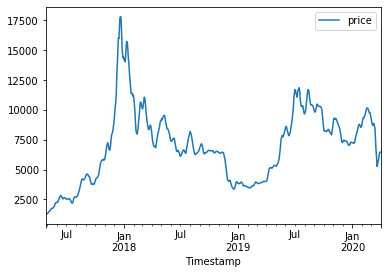

In [257]:
# 시각화
train.plot()
plt.show()

#### ARIMA 분석 방법

##### 1. AR모델로 자신의 과거를 정보로 사용하는 개념(현재의 상태는 이전의 상태를 참고해서 계산된다)
##### 2. MA모델로 이전 항에서의 오차를 이용하여 현재 항의 상태를 추론하겠다
##### 파이썬에서는 statsmodel 모듈로 arima분석을 수행할 수 있다. 

In [258]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

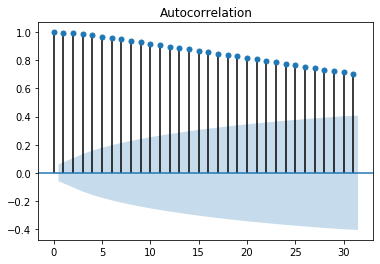

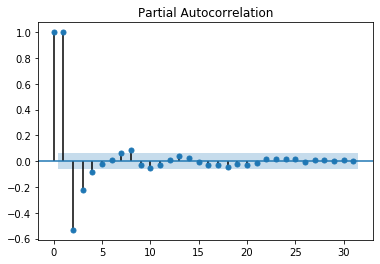

In [259]:
#ARIMA 의 order 파라미터 p,d,q의 최적 조합 찾기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(train)
plot_pacf(train)
plt.show()
# 자기상관은 항상 양 
# 급격 감소 q=1

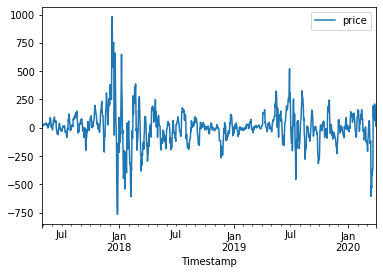

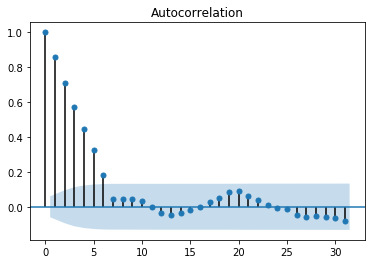

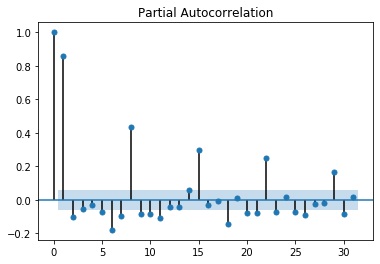

In [260]:
# 적절 차분 차수 d 계산 
tmp=train.diff(periods=1).iloc[1:] #2차 차분
tmp.plot()
plot_acf(tmp)
plot_pacf(tmp)
plt.show()
# 시계열 정상상태. (p, d, q) = (0, 1, 1)

In [261]:
# AR=2, 차분=1, MA=2 파라미터로 ARIMA 모델을 학습 -> 파라미터 조정 필요하나 생략함 따라서 임의설정
model = ARIMA(train.price.values, order=(0,1,1))
model_fit = model.fit(trend='c', full_output=True, disp=True)

In [262]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1069
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -6476.567
Method:                       css-mle   S.D. of innovations            103.472
Date:                Sat, 25 Apr 2020   AIC                          12959.133
Time:                        17:04:49   BIC                          12974.057
Sample:                             1   HQIC                         12964.787
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9048      5.315      0.923      0.356      -5.513      15.323
ma.L1.D.y      0.6802      0.015     44.525      0.000       0.650       0.710
                                    Roots           

In [263]:
# P 값이 t-test
# 0.05 수준에서 상수 부적절
# c->nc
model = ARIMA(train.price.values, order=(0,1,1))
model_fit = model.fit(trend='nc', full_output=True, disp=True)

In [264]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1069
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -6476.992
Method:                       css-mle   S.D. of innovations            103.513
Date:                Sat, 25 Apr 2020   AIC                          12957.983
Time:                        17:04:49   BIC                          12967.932
Sample:                             1   HQIC                         12961.752
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.D.y      0.6803      0.015     44.542      0.000       0.650       0.710
                                    Roots                                    
                  Real          Imaginary           M

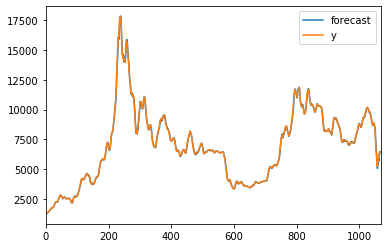

In [265]:
# 학습 데이터 예측 결과 -> 양호
fig = model_fit.plot_predict()

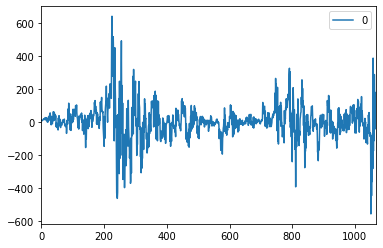

In [266]:
# 잔차의 변동 시각화
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
# 폭이 일정해야 좋음 -> 불규칙한 형태이나 절댓값 600이하로 양호

#### 평가

In [267]:
# 4월 한달간(25일) 시세 차트인 test 데이터 프레임 사용
pred_model = model_fit.forecast(steps=25)

In [268]:
# 25일간 예측 데이터
pred=pred_model[0].tolist()

In [269]:
# 실제 25일간 데이터
test_y=test.price.values

In [270]:
# 시각화
pred_lower = []
pred_upper = []
for lower_upper in pred_model[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_lower.append(lower)
    pred_upper.append(upper)

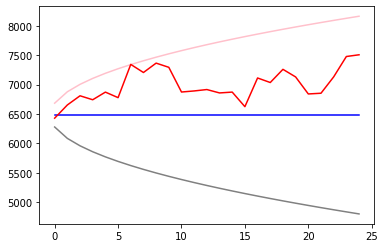

In [271]:
plt.plot(pred, color="blue") # 예측 가격
plt.plot(pred_lower, color = "gray") # 예측 최저가격
plt.plot(pred_upper, color = "pink") # 예측 최고가격
plt.plot(test_y, color = "red") # 실제가격

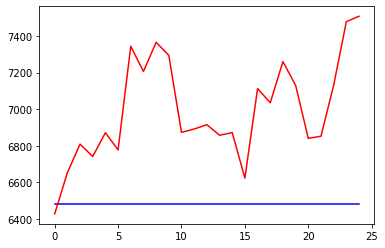

In [272]:
plt.plot(pred, color="blue") # 예측 가격
plt.plot(test_y, color = "red") # 실제가격

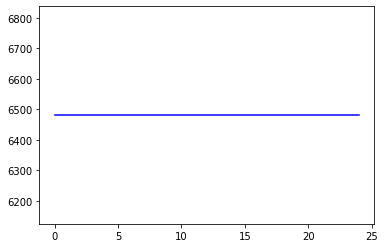

In [273]:
plt.plot(pred, color="blue") # 예측 가격

#### Additive 모델

In [274]:
conda install -c conda-forge fbprophet

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\jih02\AppData\Local\Continuum\anaconda3

  added / updated specs:
    - fbprophet


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.8.3                |   py37hc8dfbb8_1         3.1 MB  conda-forge
    convertdate-2.1.3          |          py_1000          30 KB  conda-forge
    ephem-3.7.7.1              |   py37hfa6e2cd_0         741 KB  conda-forge
    fbprophet-0.6              |   py37h6538335_0         521 KB  conda-forge
    holidays-0.10.1            |             py_0          56 KB  conda-forge
    libpython-2.0              |           py37_0          47 KB  conda-forge
    lunarcalendar-0.0.9        |             py_0          20 KB  conda-forge
    m2w64-binutils-2.25.1      |                5        44.3 MB
    m2w64-bzip2-1.0.6          |                6         100 KB
  



==> WARNING: A newer version of conda exists. <==
  current version: 4.7.12
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base -c defaults conda


WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename C:\Users\jih02\AppData\Local\Continuum\anaconda3\Lib\site-packages\matplotlib\mpl-data\fonts\ttf\DejaVuSans.ttf.  Please remove this file manually (you may need to reboot to free file handles)


In [ ]:
from fbprophet import Prophet